<a href="https://colab.research.google.com/github/JasonDepblu/potential-spork/blob/main/e8_of_content_based_filtering_explainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
pip install shap

In [107]:
# %%
import time
import pandas as pd
import numpy as np
import random
import mpl_toolkits.axisartist as ast
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow import keras
import tensorflow as tf
from keras import layers, models, optimizers
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import copy
import shap

In [108]:
# load the data
dsc_up_df = pd.read_csv(r'/content/dsc_up_e8.csv')
car_dict_df = pd.read_csv(r'/content/car_dict_e8.csv')

dsc_up_df = dsc_up_df.replace({np.NaN: 0})
car_dict_df = car_dict_df.replace({np.NaN: 0})

dsc_up = dsc_up_df.values
car_dict = car_dict_df.values

print(dsc_up.shape)
print(car_dict.shape)

(5520, 38)
(142, 160)


In [109]:
# load the predict data of year 21-23
dsc_up_pre_df = pd.read_csv(r'/content/dsc_up_e8_pre.csv')
car_dict_pre_df = pd.read_csv(r'/content/car_dict_e8_pre.csv')

dsc_up_pre_df = dsc_up_pre_df.replace({np.NaN: 0})
car_dict_pre_df = car_dict_pre_df.replace({np.NaN: 0})

dsc_up_pre = dsc_up_pre_df.values
car_dict_pre = car_dict_pre_df.values

print(dsc_up_pre.shape)
print(car_dict_pre.shape)


(5520, 38)
(142, 160)


In [110]:
num_cars = len(car_dict)
num_cars_pre = len(car_dict_pre)
print(f'The No. of cars in fundamental model dataset : {num_cars}')
print(f'The No. of cars in prediction dataset : {num_cars_pre}')

The No. of cars in fundamental model dataset : 142
The No. of cars in prediction dataset : 142


In [111]:
# balance dsc_up samples
dsc_up_bal = np.empty(shape=(1, dsc_up.shape[1]))

for i in range(num_cars):
  if len(dsc_up[dsc_up[:, 32] == i]) > 300:
    ran_row_bal = np.random.choice(np.arange(len(dsc_up[dsc_up[:, 32] == i])), size=300, replace=False)
    dsc_up_bali = dsc_up[dsc_up[:, 32] == i][ran_row_bal]
  else:
    dsc_up_bali = dsc_up[dsc_up[:, 32] == i]
  dsc_up_bal = np.concatenate((dsc_up_bal, dsc_up_bali), axis=0)
dsc_up = dsc_up_bal[1:]
print(dsc_up.shape)

(4945, 38)


In [112]:
# load the label
print(f'The shape of cars dict of the fundamental model dataset : {car_dict.shape}')
print(f'The shape of users list of the fundamental model dataset : {dsc_up.shape}')

print(f'The shape of cars dict of the prediction dataset : {car_dict_pre.shape}')
print(f'The shape of users list of the prediction dataset : {dsc_up_pre.shape}')

ys_up = dsc_up[:, 32]
ys_up_pre = dsc_up_pre[:, 32]
print(f'The label of which user choosed which car in fundamental dataset : {ys_up}')
print(f'The label of which user choosed which car in prediction dataset : {ys_up_pre}')

The shape of cars dict of the fundamental model dataset : (142, 160)
The shape of users list of the fundamental model dataset : (4945, 38)
The shape of cars dict of the prediction dataset : (142, 160)
The shape of users list of the prediction dataset : (5520, 38)
The label of which user choosed which car in fundamental dataset : [0 0 0 ... 141 141 141]
The label of which user choosed which car in prediction dataset : [37 38 121 ... 24 23 23]


In [113]:
# transfer the label of fundamental dataset to onehot_code
ys = copy.copy(ys_up.reshape(len(ys_up), 1))
ys -= 1
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(ys)
ys = onehot_encoded
print(f'The shape of the label of fundamental dataset to onehot_code : {ys.shape}')

# transfer the label of prediction dataset to onehot_code
ys_pre = copy.copy(ys_up_pre.reshape(len(ys_up_pre), 1))
ys_pre -= 1
onehot_encoder_pre = OneHotEncoder(sparse_output=False)
onehot_encoded_pre = onehot_encoder_pre.fit_transform(ys_pre)
ys_pre = onehot_encoded_pre
print(f'The shape of the label of prediction dataset to onehot_code : {ys_pre.shape}')

The shape of the label of fundamental dataset to onehot_code : (4945, 142)
The shape of the label of prediction dataset to onehot_code : (5520, 142)


In [114]:
# column of last feature from 0 and +1
col_last_feature_car = 156
# 80
col_last_feature_user = 29

car_unscaled = car_dict[:, 1:col_last_feature_car]
car_pre_unscaled = car_dict_pre[:, 1:col_last_feature_car]
user_unscaled = dsc_up[:, 1:col_last_feature_user]
user_pre_unscaled = dsc_up_pre[:, 1:col_last_feature_user]


# generate the gaussian random no. to budget feature
mu_budget = 0
sigma_budget = 1.5

for i in range(len(user_unscaled)):
    user_unscaled[i, 24] += random.gauss(mu_budget, sigma_budget)

for i in range(len(user_pre_unscaled)):
    user_pre_unscaled[i, 24] += random.gauss(mu_budget, sigma_budget)

# scaling the data
scalerCar = StandardScaler()
scalerCar.fit(car_dict[:, 1:col_last_feature_car])
car = scalerCar.transform(car_dict[:, 1:col_last_feature_car])
car_pre = scalerCar.transform(car_dict_pre[:, 1:col_last_feature_car])

scalerUser = StandardScaler()
scalerUser.fit(dsc_up[:, 1:col_last_feature_user])
user = scalerUser.transform(dsc_up[:, 1:col_last_feature_user])
user_pre = scalerUser.transform(dsc_up_pre[:, 1:col_last_feature_user])

print(np.allclose(car_unscaled.astype(float), scalerCar.inverse_transform(car)))
print(np.allclose(user_unscaled.astype(float), scalerUser.inverse_transform(user)))
print(np.allclose(car_pre_unscaled.astype(float), scalerCar.inverse_transform(car_pre)))
print(np.allclose(user_pre_unscaled.astype(float), scalerUser.inverse_transform(user_pre)))

True
True
True
True


In [115]:
car_unscaled[1, -1]

69.8

In [116]:
# func for generating num_items users of different cars
def gen_user_vecs(user_vec, num_items):
    """ given a user vector return:
        user predict matrix to match the size of item_vecs """
    user_vecs = np.tile(user_vec, (1, num_items))
    return user_vecs

def gen_car_vecs(car_vec, num_users):
    car_vecs = np.tile(car_vec, (num_users, 1))
    return car_vecs

PCA(n_components=10)
[0.06995533 0.06614023 0.061137   0.05074357 0.04546653 0.04072884
 0.03931714 0.03887988 0.03783125 0.03704596]
PCA(n_components=15)
[0.32200143 0.13771627 0.10418725 0.06278649 0.04918918 0.03890272
 0.03254932 0.02665964 0.02334289 0.0206165  0.01733894 0.01606789
 0.0124296  0.01181082 0.01047612]


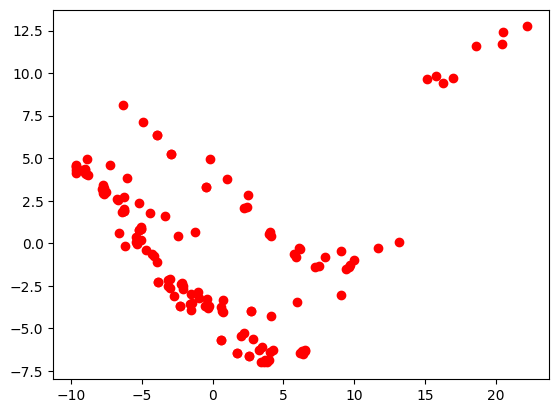

In [117]:
# pca analysis
pca_25 = PCA(n_components=10)
print(pca_25)
pca_25.fit(user)
print(pca_25.explained_variance_ratio_)

# %%
pca_30 = PCA(n_components=15)
print(pca_30)
pca_30.fit(car[:, 1:157])
print(pca_30.explained_variance_ratio_)
c_trans = pca_30.transform(car[:, 1:157])
plt.plot(c_trans[:, 0], c_trans[:, 1], 'ro')


In [118]:
# generate num_items users for different cars
user_vecs = gen_user_vecs(user, len(car_dict))
user_vecs = user_vecs.reshape(-1, user.shape[1])
car_vecs = gen_car_vecs(car, len(dsc_up))
ys = ys.reshape(-1, 1)
print(f'The shape of user matrix in fundamental dataset : {user_vecs.shape}')
print(f'The shape of car matrix in fundamental dataset : {car_vecs.shape}')
print(f'The shape of label matrix in fundamental dataset : {ys.shape}')

user_pre_vecs = gen_user_vecs(user_pre, len(car_dict_pre))
user_pre_vecs = user_pre_vecs.reshape(-1, user_pre.shape[1])
car_pre_vecs = gen_car_vecs(car_pre, len(dsc_up_pre))
ys_pre = ys_pre.reshape(-1, 1)
print(f'The shape of user matrix in prediction dataset : {user_pre_vecs.shape}')
print(f'The shape of car matrix in prediction dataset : {car_pre_vecs.shape}')
print(f'The shape of label matrix in fundamental dataset : {ys_pre.shape}')

The shape of user matrix in fundamental dataset : (702190, 28)
The shape of car matrix in fundamental dataset : (702190, 155)
The shape of label matrix in fundamental dataset : (702190, 1)
The shape of user matrix in prediction dataset : (783840, 28)
The shape of car matrix in prediction dataset : (783840, 155)
The shape of label matrix in fundamental dataset : (783840, 1)


In [119]:
print(ys[ys == 0].shape)
print(ys_pre[ys_pre == 0].shape)

(697245,)
(778320,)


In [120]:
randnum = random.randint(0, 100)
print(randnum)
random.seed(randnum)

18


In [121]:
# case 3
# Random choose the users which label is 0 in fundamental dataset

user_vecs_one = user_vecs[(ys == 1)[:, 0]]
user_vecs_zero = user_vecs[(ys == 0)[:, 0]]
num_users = user_vecs_one.shape[0]
num_zeros = user_vecs_zero.shape[0]
random.seed(randnum)

sample_row = np.random.choice(np.arange(num_zeros), size=np.ceil(num_users * 1.2).astype(int), replace=False)
user_vecs_zero = user_vecs_zero[sample_row]
user_vecs = np.concatenate((user_vecs_zero, user_vecs_one), axis=0)

random.seed(44)
shuffle_row = np.random.choice(np.arange(0,len(user_vecs)), len(user_vecs), replace=False)
user_vecs = user_vecs[shuffle_row]
print(f'The shape of the users data in fundatmental dataset after balancing : {user_vecs.shape}')

The shape of the users data in fundatmental dataset after balancing : (10879, 28)


In [122]:
# case3
# Random choose the cars which label is 0 in fundamental dataset

car_vecs_one = car_vecs[(ys == 1)[:, 0]]
car_vecs_zero = car_vecs[(ys == 0)[:, 0]][sample_row]
car_vecs = np.concatenate((car_vecs_zero, car_vecs_one), axis=0)

car_vecs = car_vecs[shuffle_row]
print(f'The shape of the cars data in fundatmental dataset after balancing : {car_vecs.shape}')

The shape of the cars data in fundatmental dataset after balancing : (10879, 155)


In [123]:
# case 3
# Random choose the label which is 0 in fundamental dataset
ys_one = ys[(ys == 1)[:, 0]]
ys_zero = ys[(ys == 0)[:, 0]][sample_row]
ys = np.concatenate((ys_zero, ys_one), axis=0)

ys = ys[shuffle_row]
print(f'The shape of label data in fundatmental dataset after balancing : {ys.shape}')

The shape of label data in fundatmental dataset after balancing : (10879, 1)


In [124]:
# Random choose the users which label is 0 in prediction dataset

user_pre_vecs_one = user_pre_vecs[(ys_pre == 1)[:, 0]]
user_pre_vecs_zero = user_pre_vecs[(ys_pre == 0)[:, 0]]
num_users_pre = user_pre_vecs_one.shape[0]
num_zeros_pre = user_pre_vecs_zero.shape[0]
random.seed(randnum)

sample_row_pre = np.random.choice(np.arange(num_zeros_pre), size=np.ceil(num_users_pre * 1.2).astype(int), replace=False)
user_pre_vecs_zero = user_pre_vecs_zero[sample_row_pre]
user_pre_vecs = np.concatenate((user_pre_vecs_zero, user_pre_vecs_one), axis=0)

random.seed(54)
shuffle_row_pre = np.random.choice(np.arange(0,len(user_pre_vecs)), len(user_pre_vecs), replace=False)
user_pre_vecs = user_pre_vecs[shuffle_row_pre]
# user_pre_vecs = user_vecs[shuffle_row_pre]??
print(f'The shape of the users data in fundatmental dataset after balancing : {user_pre_vecs.shape}')

The shape of the users data in fundatmental dataset after balancing : (12144, 28)


In [125]:
# Random choose the cars which label is 0 in prediction dataset

car_pre_vecs_one = car_pre_vecs[(ys_pre == 1)[:, 0]]
car_pre_vecs_zero = car_pre_vecs[(ys_pre == 0)[:, 0]][sample_row_pre]
car_pre_vecs = np.concatenate((car_pre_vecs_zero, car_pre_vecs_one), axis=0)

car_pre_vecs = car_pre_vecs[shuffle_row_pre]
print(f'The shape of the cars data in prediction dataset after balancing : {car_pre_vecs.shape}')

The shape of the cars data in prediction dataset after balancing : (12144, 155)


In [126]:
# Random choose the label which is 0 in prediction dataset
ys_pre_one = ys_pre[(ys_pre == 1)[:, 0]]
ys_pre_zero = ys_pre[(ys_pre == 0)[:, 0]][sample_row_pre]
ys_pre = np.concatenate((ys_pre_zero, ys_pre_one), axis=0)

ys_pre = ys_pre[shuffle_row_pre]
print(f'The shape of label data in prediction dataset after balancing : {ys_pre.shape}')

The shape of label data in prediction dataset after balancing : (12144, 1)


In [127]:
# case 3
# 对所有数据进行拆分以获取训练集和测试集
(user_train, user_test,
 car_train, car_test,
 ys_train, ys_test) = train_test_split(user_vecs, car_vecs, ys, train_size=0.8, shuffle=True, stratify=ys, random_state=2023)

# 对测试集进行进一步拆分以获得验证集和最终的测试集
(user_val, user_test,
 car_val, car_test,
 ys_val, ys_test) = train_test_split(user_test, car_test, ys_test, train_size=0.5, shuffle=True, stratify=ys_test, random_state=2023)

In [128]:
print(f"cars training data shape:{car_train.shape}")
print(f"cars validating data shape:{car_val.shape}")
print(f"cars testing data shape:{car_test.shape}")

print(f"users training data shape:{user_train.shape}")
print(f"users validating data shape:{user_val.shape}")
print(f"users testing data shape:{user_test.shape}")

print(f"ys training data shape:{ys_train.shape}")
print(f"ys validating data shape:{ys_val.shape}")
print(f"ys testing data shape:{ys_test.shape}")

cars training data shape:(8703, 155)
cars validating data shape:(1088, 155)
cars testing data shape:(1088, 155)
users training data shape:(8703, 28)
users validating data shape:(1088, 28)
users testing data shape:(1088, 28)
ys training data shape:(8703, 1)
ys validating data shape:(1088, 1)
ys testing data shape:(1088, 1)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 28)]                 0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 155)]                0         []                            
                                                                                                  
 sequential_6 (Sequential)   (None, 32)                   44448     ['input_7[0][0]']             
                                                                                                  
 sequential_7 (Sequential)   (None, 32)                   76960     ['input_8[0][0]']             
                                                                                            

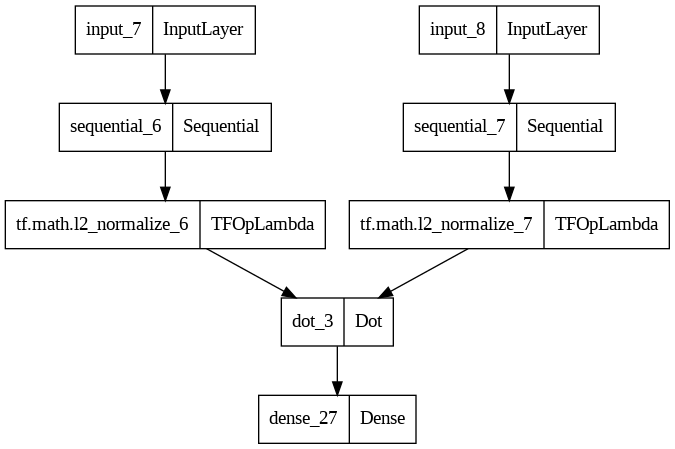

In [129]:
num_user_features = col_last_feature_user-1
num_car_features = col_last_feature_car-1
num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='relu'),
])
car_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='relu'),
])

input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

input_car = tf.keras.layers.Input(shape=(num_car_features))
vc = car_NN(input_car)
vc = tf.linalg.l2_normalize(vc, axis=1)

d_out = tf.keras.layers.Dot(axes=1)([vu, vc])
output = tf.keras.layers.Dense(1, activation='sigmoid')(d_out)

model = tf.keras.Model([input_user, input_car], output)
model.summary()
tf.keras.utils.plot_model(model, "/content/my_model.png")

In [130]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=cost_fn)

In [131]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5, # number of epochs to wait
                                                  restore_best_weights=True)


In [132]:
tf.random.set_seed(1)
# model.fit([user_train, car_train], ys_train, epochs=12)
history = model.fit([user_train, car_train], ys_train,
                    validation_data=([user_val, car_val], ys_val),
                    epochs=30,
                    callbacks=[early_stopping])


Epoch 1/30
272/272 [==============================] - 2s 4ms/step - loss: 0.2263 - val_loss: 0.2225
Epoch 2/30
272/272 [==============================] - 1s 3ms/step - loss: 0.1976 - val_loss: 0.1970
Epoch 3/30
272/272 [==============================] - 1s 3ms/step - loss: 0.1767 - val_loss: 0.1752
Epoch 4/30
272/272 [==============================] - 1s 4ms/step - loss: 0.1573 - val_loss: 0.1635
Epoch 5/30
272/272 [==============================] - 1s 4ms/step - loss: 0.1419 - val_loss: 0.1483
Epoch 6/30
272/272 [==============================] - 1s 4ms/step - loss: 0.1249 - val_loss: 0.1403
Epoch 7/30
272/272 [==============================] - 1s 3ms/step - loss: 0.1129 - val_loss: 0.1299
Epoch 8/30
272/272 [==============================] - 1s 3ms/step - loss: 0.1041 - val_loss: 0.1271
Epoch 9/30
272/272 [==============================] - 1s 3ms/step - loss: 0.0993 - val_loss: 0.1216
Epoch 10/30
272/272 [==============================] - 1s 3ms/step - loss: 0.0943 - val_loss: 0.1162

In [101]:
model.evaluate([user_val, car_val], ys_val)

34/34 [==============================] - 0s 2ms/step - loss: 0.1382


0.13817864656448364

In [102]:
model.evaluate([user_val[(ys_val == 0)[:, 0]], car_val[(ys_val == 0)[:, 0]]], ys_val[(ys_val == 0)[:, 0]])
model.evaluate([user_val[(ys_val == 1)[:, 0]], car_val[(ys_val == 1)[:, 0]]], ys_val[(ys_val == 1)[:, 0]])

16/16 [==============================] - 0s 2ms/step - loss: 0.1500


0.14999349415302277

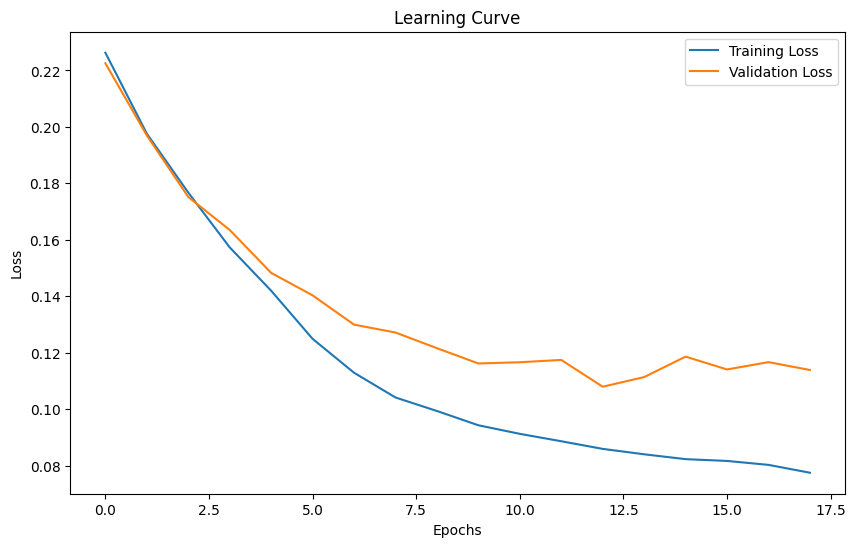

In [133]:
# import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


用validation set调参

In [134]:
ys_p_val = model.predict([[user_val, car_val]])

34/34 [==============================] - 0s 2ms/step


In [135]:
# print the confusion matrix & report of validation set
ys_p_val_binary = np.where(ys_p_val > 0.64, 1, 0)
confusion_val = confusion_matrix(ys_val, ys_p_val_binary)
print(confusion_val)
print(classification_report(ys_val, ys_p_val_binary))

[[515  79]
 [ 87 407]]
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.86       594
         1.0       0.84      0.82      0.83       494

    accuracy                           0.85      1088
   macro avg       0.85      0.85      0.85      1088
weighted avg       0.85      0.85      0.85      1088



In [136]:
ys_test.shape

(1088, 1)

In [137]:
model.evaluate([user_test[(ys_test == 0)[:, 0]], car_test[(ys_test == 0)[:, 0]]], ys_test[(ys_test == 0)[:, 0]])
model.evaluate([user_test[(ys_test == 1)[:, 0]], car_test[(ys_test == 1)[:, 0]]], ys_test[(ys_test == 1)[:, 0]])

16/16 [==============================] - 0s 2ms/step - loss: 0.0918


0.09181083738803864

In [138]:
ys_p_test = model.predict([[user_test, car_test]])
ys_p_test_vs = np.concatenate((ys_p_test, ys_test), axis=1)
ys_test_df = pd.DataFrame(ys_p_test_vs)
ys_test_df.to_csv(r'/content/ys_p_test_6epoch.csv', encoding='UTF-8')

34/34 [==============================] - 0s 2ms/step


In [139]:
# print the confusion matrix & report of test set
print(confusion_matrix(ys_test, np.round(ys_p_test)))
print(classification_report(ys_test, np.round(ys_p_test)))

[[484 109]
 [ 44 451]]
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.86       593
         1.0       0.81      0.91      0.85       495

    accuracy                           0.86      1088
   macro avg       0.86      0.86      0.86      1088
weighted avg       0.87      0.86      0.86      1088



In [140]:
ys_p_test_binary = np.where(ys_p_test > 0.8, 1, 0)
confusion_test = confusion_matrix(ys_test, ys_p_test_binary)
print(confusion_test)
print(classification_report(ys_test, ys_p_test_binary))

[[558  35]
 [232 263]]
              precision    recall  f1-score   support

         0.0       0.71      0.94      0.81       593
         1.0       0.88      0.53      0.66       495

    accuracy                           0.75      1088
   macro avg       0.79      0.74      0.74      1088
weighted avg       0.79      0.75      0.74      1088



AUC: 0.9209974960396546


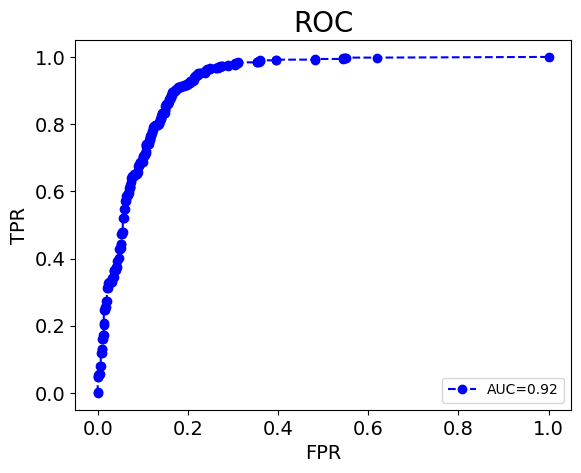

In [141]:
# calculate the auc & roc
FPR, TPR, thresholds = metrics.roc_curve(ys_test, ys_p_test)
AUC = auc(FPR, TPR)
print('AUC:',AUC)
plt.rc('font', family='', size=14)
plt.plot(FPR,TPR,label="AUC={:.2f}" .format(AUC),marker = 'o',color='b',linestyle='--')
plt.legend(loc=4, fontsize=10)
plt.title('ROC',fontsize=20)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.show()

# 可视化模型的权重

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# 提取权重
user_weights = user_NN.get_weights()
car_weights = car_NN.get_weights()



In [ ]:
# 可视化函数
def visualize_weights(weights, network_name):
    for i, weight_matrix in enumerate(weights):
        # 权重的shape，如果是偏置项，则是一维数组
        if len(weight_matrix.shape) == 2:
            plt.figure(figsize=(12, 6))
            plt.imshow(weight_matrix, cmap='viridis')
            plt.colorbar()
            plt.title(f"{network_name} - Layer {i + 1} Weights")
            plt.show()
        else:
            plt.figure(figsize=(12, 2))
            plt.imshow(weight_matrix.reshape(1, -1), cmap='viridis', aspect='auto')
            plt.colorbar()
            plt.title(f"{network_name} - Layer {i + 1} Biases")
            plt.show()



In [ ]:
# 为用户神经网络和汽车神经网络的权重进行可视化
visualize_weights(user_weights, "User Neural Network")
visualize_weights(car_weights, "Car Neural Network")

# ##########

In [ ]:
ys_p_train = model.predict([[user_train, car_train]])

272/272 [==============================] - 1s 1ms/step


In [ ]:
# print the confusion matrix & report
print(confusion_matrix(ys_train, np.round(ys_p_train)))
print(classification_report(ys_train, np.round(ys_p_train)))

[[3542 1217]
 [ 322 3622]]
              precision    recall  f1-score   support

         0.0       0.92      0.74      0.82      4759
         1.0       0.75      0.92      0.82      3944

    accuracy                           0.82      8703
   macro avg       0.83      0.83      0.82      8703
weighted avg       0.84      0.82      0.82      8703



In [ ]:
# predict the users of year 21-23 whether buy the cars in scope
ys_p_pre = model.predict([user_pre_vecs, car_pre_vecs])

380/380 [==============================] - 1s 1ms/step


In [ ]:
# print the confusion matrix & report
print(confusion_matrix(ys_pre, np.round(ys_p_pre)))
print(classification_report(ys_pre, np.round(ys_p_pre)))

[[4929 1695]
 [ 453 5067]]
              precision    recall  f1-score   support

         0.0       0.92      0.74      0.82      6624
         1.0       0.75      0.92      0.83      5520

    accuracy                           0.82     12144
   macro avg       0.83      0.83      0.82     12144
weighted avg       0.84      0.82      0.82     12144



AUC: 0.9086418978199607


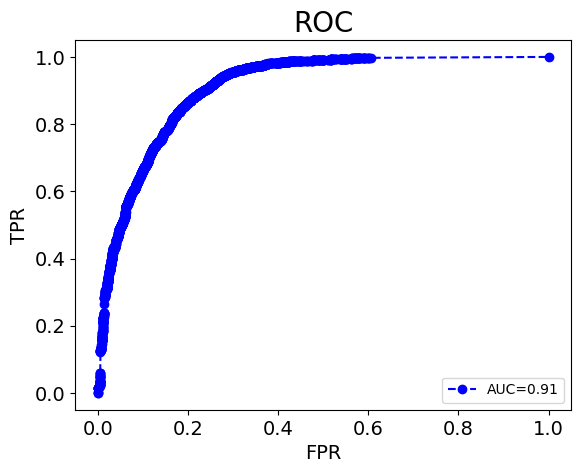

In [ ]:
# calculate the auc & roc
FPR, TPR, thresholds = metrics.roc_curve(ys_pre, ys_p_pre)
AUC = auc(FPR, TPR)
print('AUC:',AUC)
plt.rc('font', family='', size=14)
plt.plot(FPR,TPR,label="AUC={:.2f}" .format(AUC),marker = 'o',color='b',linestyle='--')
plt.legend(loc=4, fontsize=10)
plt.title('ROC',fontsize=20)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.show()

基于某个用户，预测不同的车的购买倾向

In [ ]:
list = []
for i in range(len(dsc_up)):
  if dsc_up[i, 32] == 7:
    list.append(i)
print(list)

[2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 220

In [ ]:
dsc_up[2047, :]

array([3358153, 3, 3, 3, 2, 3, 3, 4, 3, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2300, 3, 7.911861159554745, 5,
       3, 24, '宋Pro', 5178, 40569, 7, '2019款 1.5T 自动豪华型', 40569],
      dtype=object)

In [ ]:
# predict the new car of new performance for specific user
# define the cars and the user
row_car_dict = np.arange(0, num_cars)
row_user_dst = [2047]
new_car = car_unscaled[row_car_dict]
new_user = gen_car_vecs(user_unscaled[row_user_dst], len(row_car_dict))

# predict the new car of new performance
new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])
print(f'target car is {dsc_up[row_user_dst, 33]}, car No. is {dsc_up[row_user_dst, 32]}')
for i in range(len(row_car_dict)):
    print(
        f'{i} :'
        f'{car_dict[row_car_dict, 91].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [ ]:
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.8] = 1
new_y_true = np.zeros((new_y_predict.shape))
new_y_true[row_car_dict == dsc_up[row_user_dst, 32]] = 1

print(confusion_matrix(new_y_true, new_y_predict))
print(classification_report(new_y_true, new_y_predict))


[[186   4]
 [  0   1]]
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       190
         1.0       0.20      1.00      0.33         1

    accuracy                           0.98       191
   macro avg       0.60      0.99      0.66       191
weighted avg       1.00      0.98      0.99       191



In [ ]:
dsc_up[row_user_dst, 32]

array([7], dtype=object)

In [ ]:
new_y_predict_vs = np.concatenate((new_y_predict, new_y_true), axis=1)
new_y_predict_vs = np.concatenate((new_car_predict, new_y_predict_vs), axis=1)
new_y_predict_df = pd.DataFrame(new_y_predict_vs)
new_y_predict_df.to_csv(r'/content/new_car_predict_vs.csv', encoding='UTF-8')

基于某款车预测不同用户的购买倾向

In [ ]:
row_car_dict = [7]
row_user_dst = np.arange(0, num_users)
new_car = gen_car_vecs(car_unscaled[row_car_dict], len(row_user_dst))
new_user = user_unscaled[row_user_dst]

new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict[row_car_dict, 91]}, car No. is {car_dict[row_car_dict, 92]}')
for i in range(min(len(row_user_dst), 200)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 29].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [ ]:
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.86] = 1
new_y_true = np.zeros((new_y_predict.shape))
new_y_true[dsc_up[row_user_dst, 32] == row_car_dict] = 1

print(confusion_matrix(new_y_true, new_y_predict))
print(classification_report(new_y_true, new_y_predict))

[[29750 13445]
 [  212   788]]
              precision    recall  f1-score   support

         0.0       0.99      0.69      0.81     43195
         1.0       0.06      0.79      0.10      1000

    accuracy                           0.69     44195
   macro avg       0.52      0.74      0.46     44195
weighted avg       0.97      0.69      0.80     44195



In [ ]:
new_y_predict_vs = np.concatenate((new_y_predict, new_y_true), axis=1)
new_y_predict_vs = np.concatenate((new_car_predict, new_y_predict_vs), axis=1)
new_y_predict_vs = np.concatenate((dsc_up[row_user_dst, 32].reshape(-1, 1), new_y_predict_vs), axis=1)
new_y_predict_df = pd.DataFrame(new_y_predict_vs)
new_y_predict_df.to_csv(r'/content/new_user_predict_vs3.csv', encoding='UTF-8')

In [ ]:
new_y_predict [new_car_predict > 0.86].shape

(14233,)

修改某款车性能参数，预测不同用户的购买倾向

In [ ]:
# 32 宋DMIDMI110km
# 56 低配影酷
car_unscaled[56, 0]

11.98

In [ ]:
# base car parameters
row_car_dict = [56]
row_user_dst = np.arange(0, num_users)
new_car_one = car_unscaled[row_car_dict]
print(new_car_one)

[[11.98 7 1 2 1 0.0 0.0 130 270 1 190 8.35 0 735 3.0 350.0 165.0 350.0
  0.0 0.0 1.0 0 0 0 1 1 0 0 4680 1901 1670 2750 1617 1610 1915 1500 5 1 2
  2 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 4 1 1 3 1 4 1 1 1 1 0.0 1 3 1 1 1 1 1
  7.0 0 39.1 58.1 59.5 66.7]]


In [ ]:
# modify the paramters of some car
new_car_one[:, 0:14] = car_unscaled[32, 0:14]
print(new_car_one)

[[17.58 4 1 3 3 0.7 5.5 81 135 1 170 7.9 110 1443 3.0 350.0 165.0 350.0
  0.0 0.0 1.0 0 0 0 1 1 0 0 4680 1901 1670 2750 1617 1610 1915 1500 5 1 2
  2 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 4 1 1 3 1 4 1 1 1 1 0.0 1 3 1 1 1 1 1
  7.0 0 39.1 58.1 59.5 66.7]]


In [ ]:
new_car = gen_car_vecs(new_car_one, len(row_user_dst))
new_user = user_unscaled[row_user_dst]

new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict[row_car_dict, 81]}, car No. is {car_dict[row_car_dict, 82]}')
for i in range(min(len(row_user_dst), 100)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 32].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [ ]:
new_y_predict_modify = np.concatenate((dsc_up[row_user_dst, 32].reshape(-1, 1), new_car_predict), axis=1)
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.8] = 1
new_y_predict_modify = np.concatenate((new_y_predict_modify, new_y_predict), axis=1)
new_y_predict_modify_df = pd.DataFrame(new_y_predict_modify)
new_y_predict_modify_df.to_csv(r'/content/new_user_predict_modify.csv', encoding='UTF-8')

In [ ]:
new_y_predict [new_car_predict > 0.8].shape

(3196,)

In [ ]:
dsc_up.shape

(9492, 33)

**修改某款车参数为未来热销车型参数，预测原有用户是否购买**

---



---



In [ ]:
dsc_up

In [ ]:
new_car = gen_car_vecs(new_car_one, len(row_user_dst))
new_user = user_unscaled[row_user_dst]

new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict_pre[row_car_dict, 91]}, car No. is {car_dict_pre[row_car_dict, 91]}')
for i in range(min(len(row_user_dst), 10000)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 29].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

155/155 [==============================] - 0s 1ms/step


NameError: ignored

In [ ]:
new_car_predict[new_car_predict > 0.8] = 1
new_y_predict_df = pd.DataFrame(new_car_predict)
new_y_predict_df.to_csv(r'/content/new_user_predict.csv', encoding='UTF-8')

In [ ]:
new_y_predict_modify = np.concatenate((dsc_up[row_user_dst, 29].reshape(-1, 1), new_car_predict), axis=1)
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.8] = 1
new_y_predict_modify = np.concatenate((new_y_predict_modify, new_y_predict), axis=1)
new_y_predict_modify_df = pd.DataFrame(new_y_predict_modify)
new_y_predict_modify_df.to_csv(r'/content/new_user_predict_modify_RAV4.csv', encoding='UTF-8')

In [ ]:
new_y_predict [new_car_predict > 0.8].shape

(6663,)

In [ ]:
dsc_up.shape

(44195, 35)

修改用户地点，预测用户购买某款车的倾向变化

In [ ]:
row_car_dict = [11]
row_user_dst = np.arange(0, num_users)
new_car_one = car_unscaled[row_car_dict]
new_car = gen_car_vecs(new_car_one, len(row_user_dst))
new_user = user_unscaled[row_user_dst]

In [ ]:
# modify the place of users
# 吉林：26 长春：295
# 广东：1 广州：115
# 广东：1 深圳：195
new_user[:, (22,24)] = [(115, 1)]
print(new_user[0:10,(22,24)])

[[115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]]


In [ ]:
new_user[0]

array([3, 3, 2, 3, 2, 3, 3, 3, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 100, 115, 12.383482437349597, 1, 0, 7],
      dtype=object)

In [ ]:
new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict[row_car_dict, 81]}, car No. is {car_dict[row_car_dict, 82]}')
for i in range(min(len(row_user_dst), 100)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 32].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [ ]:
threshold_p = 0.23
new_y_predict [new_car_predict > threshold_p].shape

(460,)

In [ ]:
num_users

9492

In [ ]:
new_y_predict_modify = np.concatenate((dsc_up[row_user_dst, 32].reshape(-1, 1), new_car_predict), axis=1)
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > threshold_p] = 1
new_y_predict_modify = np.concatenate((new_y_predict_modify, new_y_predict), axis=1)
new_y_predict_modify_df = pd.DataFrame(new_y_predict_modify)
new_y_predict_modify_df.to_csv(r'/content/new_user_predict_modify_place.csv', encoding='UTF-8')

**others：**

In [ ]:
new_car_predict = np.concatenate((new_car_predict, dsc_up[0:, 30].reshape(-1, 1)), axis=1)
new_car_predict_df = pd.DataFrame(new_car_predict)
new_car_predict_df.to_csv(r'/content/new_car_predict3.csv', encoding='UTF-8')

In [ ]:
a = np.array([0,1,2])
b = np.array([1,2,3])
print(np.dot(a,b))

8


# **E8场景预测：针对爬取的已买MPV相关车型的用户，预测他们是否会购买E8**

In [142]:
e8_pre_df = pd.read_csv(r'/content/e8_para.csv')
e8_pre_df = e8_pre_df.replace({np.NaN: 0})
e8_pre = e8_pre_df.values
e8_pre.shape


(1, 158)

In [143]:
print(car_unscaled[0].shape)
print(col_last_feature_car)

(155,)
156


In [144]:
e8_pre = e8_pre[:, 1:col_last_feature_car]
print(e8_pre.shape)
row_user_dst = np.arange(0, num_users)

(1, 155)


In [145]:
new_car_one = e8_pre
print(e8_pre)
# new car parameters
# row_car_dict = [61]
# row_user_dst = np.arange(0, num_users)
# new_car_one = car_pre_unscaled[row_car_dict]
# print(new_car_one)

[[2.500e+01 1.000e+00 2.000e+00 4.000e+00 3.000e+00 1.000e+01 5.000e-01
  4.500e+00 1.030e+02 1.800e+02 1.000e+00 1.700e+02 9.800e+00 1.160e+02
  9.500e+02 8.000e+00 2.000e+00 1.000e+00 1.000e+00 1.340e+02 3.000e+02
  1.340e+02 3.000e+02 0.000e+00 0.000e+00 1.000e+00 1.000e+00 2.000e+00
  8.000e+00 1.500e+01 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00
  1.000e+00 4.920e+03 1.900e+03 1.760e+03 2.930e+03 1.618e+03 1.640e+03
  2.175e+03 7.000e+00 2.000e+00 1.000e+00 2.000e+00 0.000e+00 0.000e+00
  2.000e+00 2.000e+00 2.000e+00 2.000e+00 1.000e+00 1.000e+00 3.000e+00
  0.000e+00 5.000e+00 3.000e+00 1.000e+00 0.000e+00 0.000e+00 3.000e+00
  3.000e+00 2.000e+00 1.000e+00 0.000e+00 3.000e+00 1.000e+00 1.000e+00
  2.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.000e+00 3.000e+00 1.000e+00 2.000e+00 3.000e+00 1.000e+00 0.000e+00
  2.000e+00 0.000e+00 1.000e+00 1.000e+00 2.000e+00 1.000e+00 2.000e+00
  5.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00 3.000e+00 3.

In [146]:
print(new_car_one[0, 0])

25.0


In [147]:
new_car = gen_car_vecs(new_car_one, len(row_user_dst))
new_user = user_unscaled[row_user_dst]

new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])



155/155 [==============================] - 0s 2ms/step


In [148]:
print(row_user_dst.shape)
print(new_user_scal.shape)
print(new_car_scal.shape)

(4945,)
(4945, 28)
(4945, 155)


In [ ]:
# print(f'target car is {car_dict_pre[row_car_dict, 91]}, car No. is {car_dict_pre[row_car_dict, 91]}')
for i in range(min(len(row_user_dst), 10000)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 29].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [149]:
new_car_predict = np.concatenate((new_car_predict, dsc_up[0:, 29].reshape(-1, 1)), axis=1)
new_car_predict_df = pd.DataFrame(new_car_predict)
new_car_predict_df.to_csv(r'/content/new_car_predict25W顶配+.csv', encoding='UTF-8')

# 通过SHAP筛选特征重要度

使用DeepExplainer

In [ ]:
pip install shap --upgrade

In [ ]:
pip install tensorflow --upgrade

In [ ]:
pip uninstall tensorflow

Found existing installation: tensorflow 2.14.0
Uninstalling tensorflow-2.14.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.14.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y

  Successfully uninstalled tensorflow-2.14.0


In [ ]:
pip uninstall shap

In [ ]:
pip install tensorflow==2.10

In [ ]:
pip install shap==0.37

# GradientExplainer

In [ ]:
background_data_user = user_train[:1000]
background_data_car = car_train[:1000]
print(background_data_user.shape)
print(background_data_car.shape)

(1000, 28)
(1000, 155)


In [ ]:
explainer = shap.GradientExplainer(model, [background_data_user, background_data_car])

In [ ]:
print(user_pre_vecs.shape)
print(car_pre_vecs.shape)

(12144, 28)
(12144, 155)


In [ ]:
# 对一些数据计算SHAP值，例如整个训练集或一个子集
# shap_values = explainer.shap_values([user_pre_vecs, car_pre_vecs])
shap_values = explainer.shap_values([user_train, car_train])

StagingError: ignored

# 使用deepExplainer解释模型特征

In [ ]:
background_data_user = user_train[:5000]
background_data_car = car_train[:5000]

In [ ]:
explainer_d = shap.DeepExplainer(model, [background_data_user, background_data_car])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [ ]:
# 对一些数据计算SHAP值，例如整个训练集或一个子集
shap_values_d = explainer_d.shap_values([new_user_scal, car_train])

StagingError: ignored

识别贡献度最大的特征：

In [ ]:
print(type(shap_values))
print(len(shap_values))

# 我们只检查第一个元素，因为您的输出显示shap_values的长度为1
first_element = shap_values[0]
print(type(first_element))
print(len(first_element))

# 现在我们看看这个列表的内容
for inner_value in first_element:
    print(type(inner_value))
    if isinstance(inner_value, np.ndarray):  # 如果它是一个ndarray，我们打印它的形状
        print(inner_value.shape)
    else:
        print(inner_value)  # 否则我们直接打印它的值



<class 'list'>
1
<class 'list'>
2
<class 'numpy.ndarray'>
(8703, 28)
<class 'numpy.ndarray'>
(8703, 155)


In [ ]:
# 计算SHAP值的平均
mean_shap_user = np.abs(shap_values[0][0]).mean(axis=0)
mean_shap_car = np.abs(shap_values[0][1]).mean(axis=0)

In [ ]:
mean_shap_user

array([3.19472588e-03, 3.73225831e-03, 4.06502428e-03, 5.15280879e-03,
       3.55875387e-03, 3.49202440e-03, 5.40692984e-03, 3.38996946e-03,
       7.12222003e-03, 7.59258579e-03, 8.04350223e-03, 6.98736289e-03,
       4.49568082e-03, 7.93708857e-03, 5.34186235e-03, 2.85107719e-03,
       1.87706600e-03, 1.33709931e-03, 1.94157332e-03, 1.10969577e-03,
       0.00000000e+00, 7.63606480e-05, 5.31858281e-03, 7.33851615e-03,
       2.13952562e-01, 4.40950728e-03, 3.30445703e-03, 4.97693019e-03])

In [ ]:
mean_shap_car

array([0.00451695, 0.00406905, 0.00100703, 0.00525461, 0.00306772,
       0.00196898, 0.00302808, 0.00262215, 0.00591595, 0.00385121,
       0.        , 0.0015429 , 0.00405516, 0.00458668, 0.00607163,
       0.00216786, 0.00220001, 0.00781154, 0.00613162, 0.00282389,
       0.00203594, 0.00318695, 0.00333979, 0.00278894, 0.00280063,
       0.00239144, 0.00246192, 0.00160111, 0.00173431, 0.00185534,
       0.00275353, 0.        , 0.00197412, 0.00192839, 0.00243326,
       0.00199226, 0.00365178, 0.00202102, 0.00088898, 0.00367558,
       0.00209961, 0.00116683, 0.00242377, 0.00271364, 0.00346376,
       0.00551697, 0.00608018, 0.00503306, 0.00308052, 0.00411869,
       0.00418603, 0.00203113, 0.00404025, 0.00073704, 0.00123666,
       0.00613474, 0.01172485, 0.00251187, 0.00306305, 0.00275297,
       0.00264194, 0.00077814, 0.00304559, 0.0025616 , 0.00229547,
       0.00205278, 0.00411184, 0.00822919, 0.00250083, 0.00580195,
       0.00262726, 0.00256564, 0.00180628, 0.0039897 , 0.00417

In [ ]:
# 找到贡献度最高的前10个特征
top_features_user = mean_shap_user.argsort()[-10:][::-1]
top_features_car = mean_shap_car.argsort()[-10:][::-1]

In [ ]:
print("Top 10 important features for User:", top_features_user)
print("Top 10 important features for Car:", top_features_car)

Top 10 important features for User: [24 10 13  9 23  8 11  6 14 22]
Top 10 important features for Car: [ 56  90  67  17 140  82 144  55  18  46]


In [ ]:
shap.plots.waterfall(shap_values[0])

TypeError: ignored

In [ ]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(mean_shap_user)

TypeError: ignored

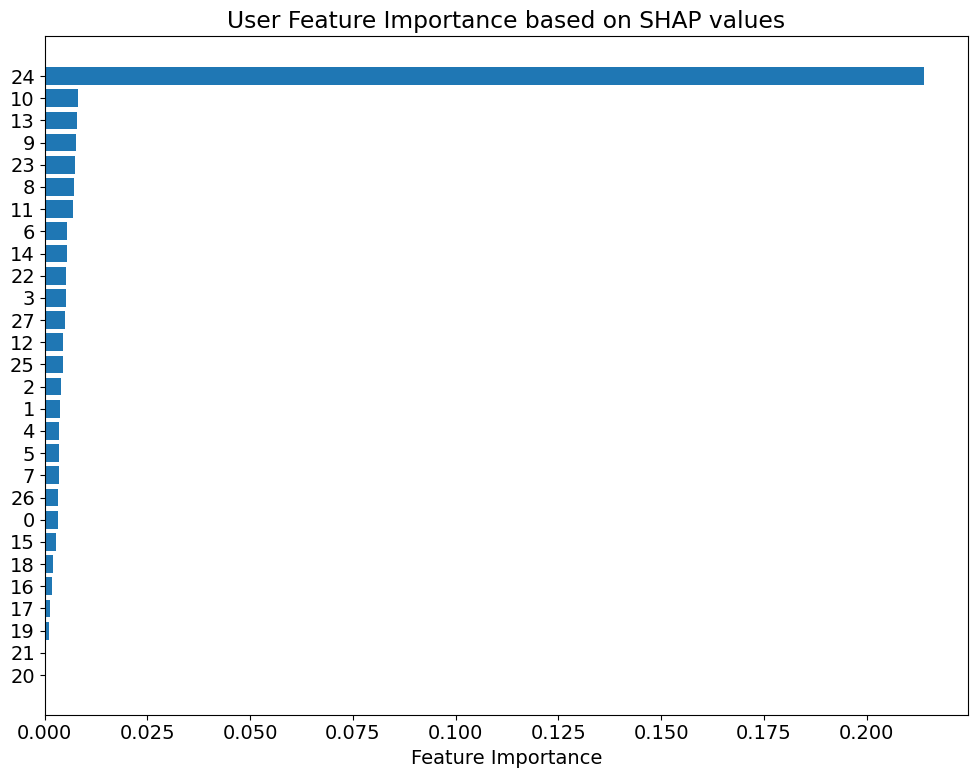

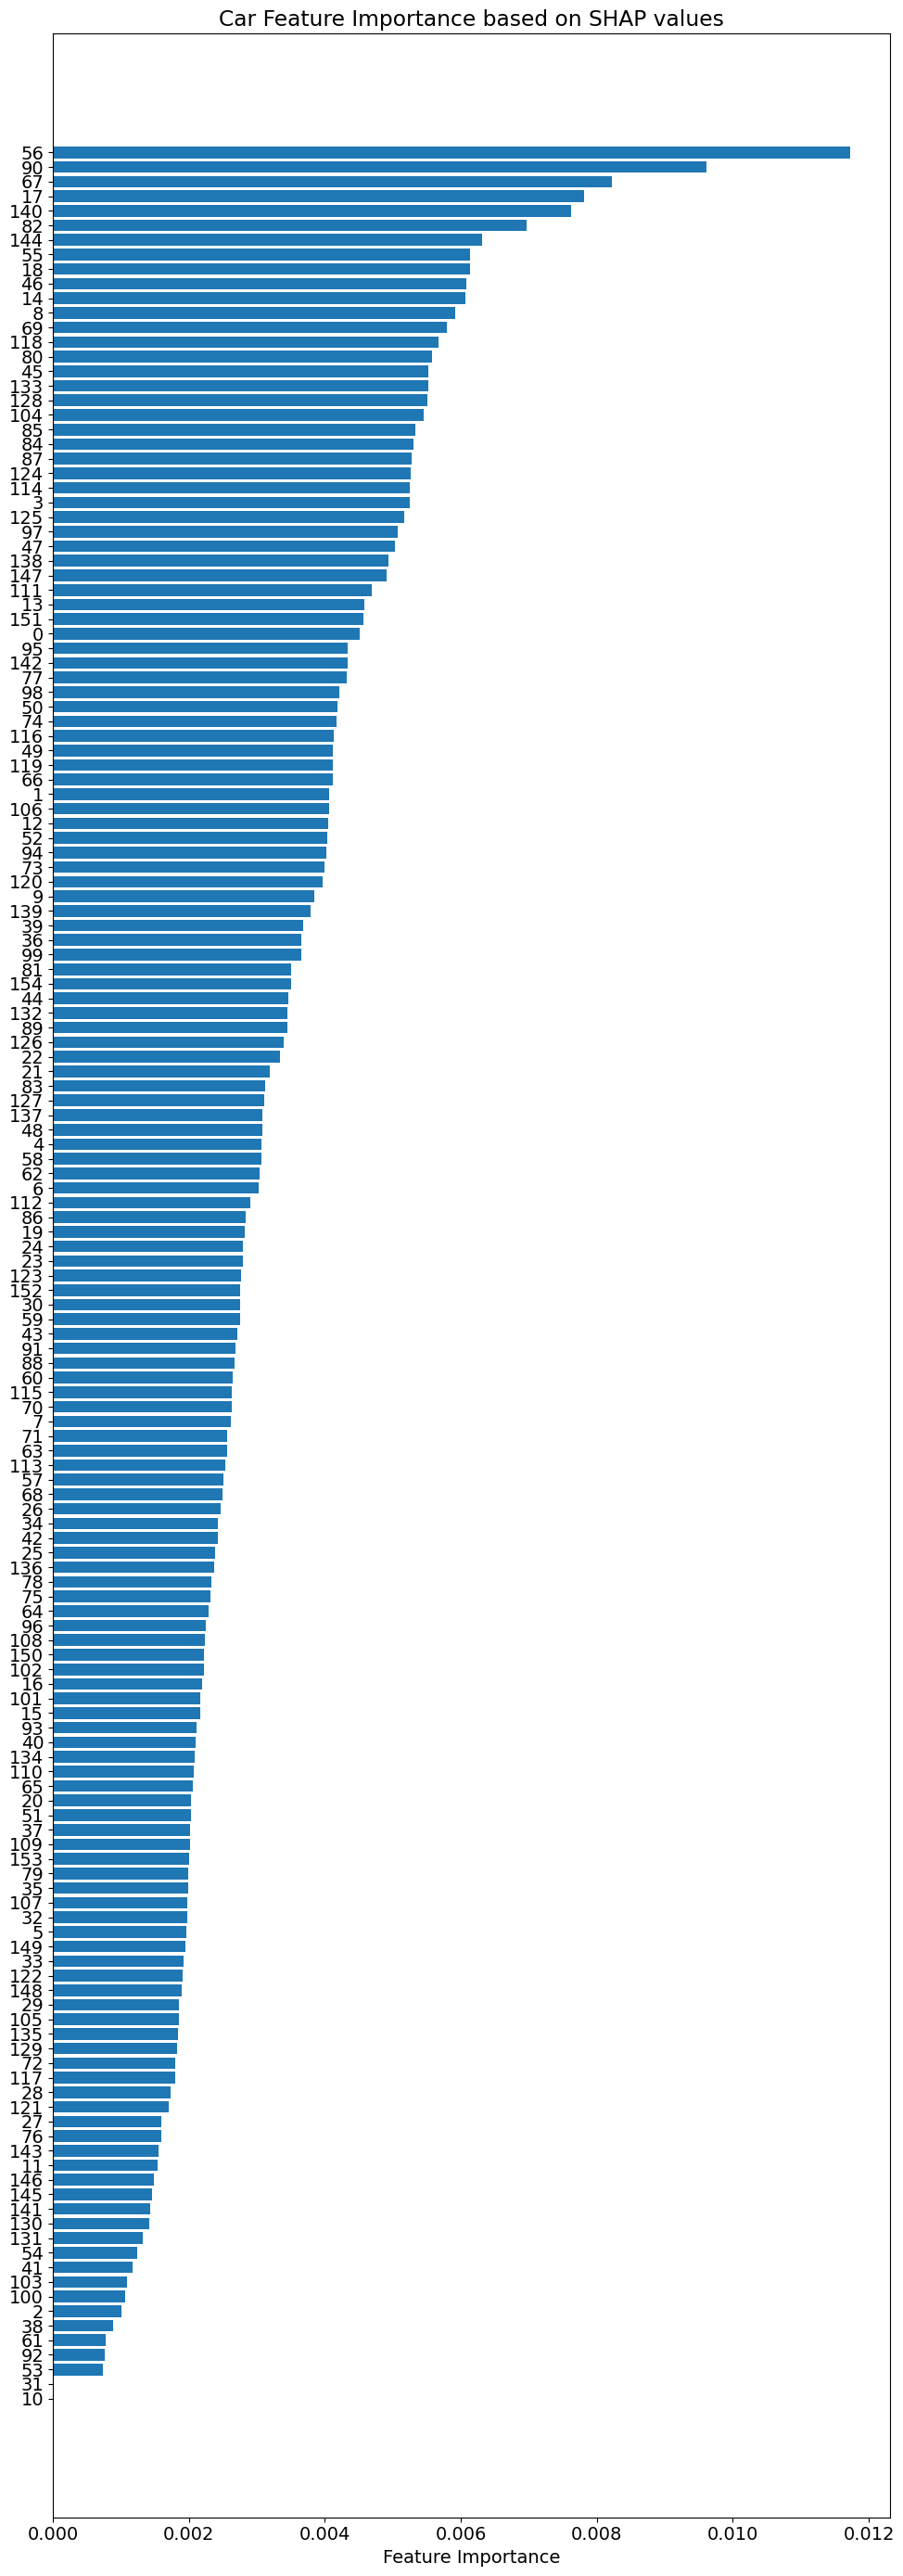

In [ ]:
# 绘制用户特征重要性
plt.figure(figsize=(10, 8))
sorted_idx_user = mean_shap_user.argsort()
plt.barh(range(user_train.shape[1]), mean_shap_user[sorted_idx_user])
plt.yticks(range(user_train.shape[1]), sorted_idx_user)
plt.xlabel('Feature Importance')
plt.title('User Feature Importance based on SHAP values')
plt.tight_layout()
plt.show()

# 绘制汽车特征重要性
plt.figure(figsize=(10, 28))
sorted_idx_car = mean_shap_car.argsort()
plt.barh(range(car_train.shape[1]), mean_shap_car[sorted_idx_car])
plt.yticks(range(car_train.shape[1]), sorted_idx_car)
plt.xlabel('Feature Importance')
plt.title('Car Feature Importance based on SHAP values')
plt.tight_layout()
plt.show()


In [ ]:
model.get_weights

<bound method Model.get_weights of <keras.src.engine.functional.Functional object at 0x7be982e43280>>

# *E8特征分析*

In [ ]:
new_user_scal.shape

(4945, 28)

In [ ]:
new_car_scal.shape

(4945, 155)

In [ ]:
background_data_user_e8 = user_train
background_data_car_e8 = car_train

In [ ]:
explainer3 = shap.GradientExplainer(model, [background_data_user_e8, background_data_car_e8])

In [ ]:
explainer3 = shap.Explainer(model, [background_data_user_e8, background_data_car_e8])

In [ ]:
shap_values3 = explainer3([new_user_scal, new_car_scal])

ValueError: ignored

In [ ]:
shap_values3

[[array([[-1.86575414e-03, -1.31368414e-02, -6.88059081e-04, ...,
           1.51685241e-03, -3.95528332e-04,  2.06832658e-03],
         [-5.93254855e-03, -4.55124245e-05, -3.81591893e-03, ...,
          -8.85180756e-03, -6.88553380e-04, -3.19920189e-04],
         [ 3.04240297e-04, -3.67832812e-03,  1.15439318e-04, ...,
          -8.06580239e-04,  6.53448951e-05,  1.33706687e-03],
         ...,
         [-1.95924862e-04, -3.21648200e-04,  1.74790469e-03, ...,
           2.68195639e-03, -1.99157745e-03, -4.88398643e-03],
         [ 2.22242647e-03,  7.53576634e-04,  1.12312962e-03, ...,
           1.23227225e-03, -1.34120369e-03, -1.38965307e-03],
         [-1.64737110e-03,  2.37477068e-02,  2.52700248e-03, ...,
          -8.29770113e-04,  1.35373281e-04,  2.91919569e-03]]),
  array([[-4.01745457e-03,  4.97278234e-04,  1.11628811e-04, ...,
           1.96995656e-03, -3.57777951e-03, -2.99346005e-03],
         [-6.34215632e-03,  1.66262535e-03, -1.87039928e-04, ...,
           2.77651916e

In [ ]:
# 创建解释器时
explainer3 = shap.PermutationExplainer(model, [background_data_user_e8, background_data_car_e8], max_evals=5000)

# 计算SHAP值
shap_values3 = explainer.shap_values([new_user_scal, new_car_scal])


StagingError: ignored

In [ ]:
shap_values_e8 = shap_values3

In [ ]:
background_data_car_e8

array([[-0.21636947, -0.80437031,  0.90195077, ...,  2.46441639,
         3.31725385,  1.75083885],
       [-0.21636947, -0.80437031,  0.90195077, ...,  2.46441639,
         3.31725385,  1.75083885],
       [-0.21636947, -0.80437031,  0.90195077, ...,  2.46441639,
         3.31725385,  1.75083885],
       ...,
       [-0.21636947, -0.80437031,  0.90195077, ...,  2.46441639,
         3.31725385,  1.75083885],
       [-0.21636947, -0.80437031,  0.90195077, ...,  2.46441639,
         3.31725385,  1.75083885],
       [-0.21636947, -0.80437031,  0.90195077, ...,  2.46441639,
         3.31725385,  1.75083885]])

In [ ]:
shap_values_e8 = explainer2.shap_values([background_data_user_e8, background_data_car_e8])

In [ ]:
print(type(shap_values_e8))
print(len(shap_values_e8))

# 我们只检查第一个元素，因为您的输出显示shap_values的长度为1
first_element = shap_values_e8[0]
print(type(first_element))
print(len(first_element))

# 现在我们看看这个列表的内容
for inner_value in first_element:
    print(type(inner_value))
    if isinstance(inner_value, np.ndarray):  # 如果它是一个ndarray，我们打印它的形状
        print(inner_value.shape)
    else:
        print(inner_value)  # 否则我们直接打印它的值



<class 'list'>
1
<class 'list'>
2
<class 'numpy.ndarray'>
(3000, 28)
<class 'numpy.ndarray'>
(3000, 155)


In [ ]:
shap_values_e8

[[array([[-1.86575414e-03, -1.31368414e-02, -6.88059081e-04, ...,
           1.51685241e-03, -3.95528332e-04,  2.06832658e-03],
         [-5.93254855e-03, -4.55124245e-05, -3.81591893e-03, ...,
          -8.85180756e-03, -6.88553380e-04, -3.19920189e-04],
         [ 3.04240297e-04, -3.67832812e-03,  1.15439318e-04, ...,
          -8.06580239e-04,  6.53448951e-05,  1.33706687e-03],
         ...,
         [-1.95924862e-04, -3.21648200e-04,  1.74790469e-03, ...,
           2.68195639e-03, -1.99157745e-03, -4.88398643e-03],
         [ 2.22242647e-03,  7.53576634e-04,  1.12312962e-03, ...,
           1.23227225e-03, -1.34120369e-03, -1.38965307e-03],
         [-1.64737110e-03,  2.37477068e-02,  2.52700248e-03, ...,
          -8.29770113e-04,  1.35373281e-04,  2.91919569e-03]]),
  array([[-4.01745457e-03,  4.97278234e-04,  1.11628811e-04, ...,
           1.96995656e-03, -3.57777951e-03, -2.99346005e-03],
         [-6.34215632e-03,  1.66262535e-03, -1.87039928e-04, ...,
           2.77651916e

In [ ]:
# 计算SHAP值的平均
mean_shap_user_e8 = np.abs(shap_values_e8.values[0][0]).mean(axis=0)
mean_shap_car_e8 = np.abs(shap_values_e8.values[0][1]).mean(axis=0)

In [ ]:
shap_values_e8.shape

(1, 2, 4945, None)

In [ ]:
shap.plots.waterfall(shap_values_e8[0][0][0, :])

TypeError: ignored

In [ ]:
shap.plots.scatter(shap_values_e8[:, "Latitude"], color=shap_values)

ValueError: ignored

In [ ]:
mean_shap_car_e8

array([0.00374083, 0.00554091, 0.00131665, 0.01590315, 0.00170232,
       0.00052676, 0.0227109 , 0.02166091, 0.01813525, 0.01284198,
       0.        , 0.00501176, 0.00288306, 0.02175879, 0.04692729,
       0.00180544, 0.00333575, 0.0250046 , 0.01191458, 0.00404405,
       0.00556381, 0.00854091, 0.0104386 , 0.00130052, 0.00128882,
       0.00524531, 0.00545234, 0.00577803, 0.00554396, 0.00478242,
       0.00187204, 0.        , 0.00228403, 0.00828498, 0.00171381,
       0.00942192, 0.00248221, 0.00165149, 0.00105121, 0.00292727,
       0.00105364, 0.00119454, 0.0050774 , 0.0029366 , 0.02140402,
       0.00212674, 0.05068669, 0.00411229, 0.00613226, 0.00495485,
       0.00494955, 0.00765747, 0.00481685, 0.02085473, 0.00092069,
       0.00802778, 0.00675456, 0.00342827, 0.00162505, 0.00246747,
       0.00157287, 0.00095724, 0.00356065, 0.00411607, 0.00422605,
       0.00769177, 0.00410611, 0.02333672, 0.00604389, 0.00788342,
       0.00088275, 0.00082415, 0.00096472, 0.00428694, 0.00375

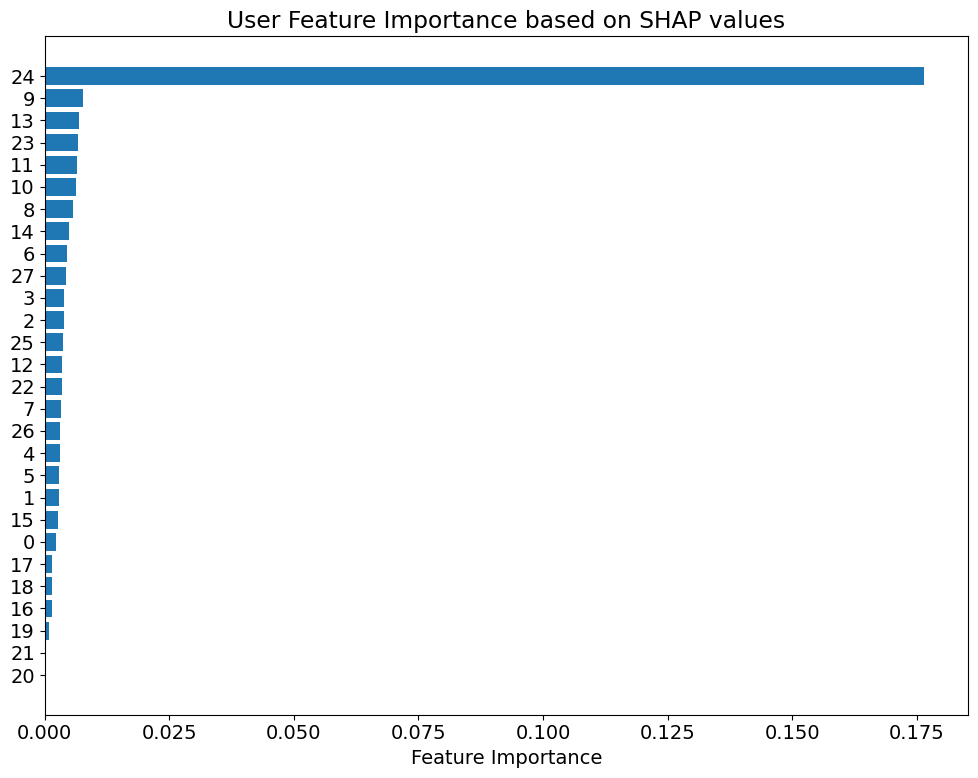

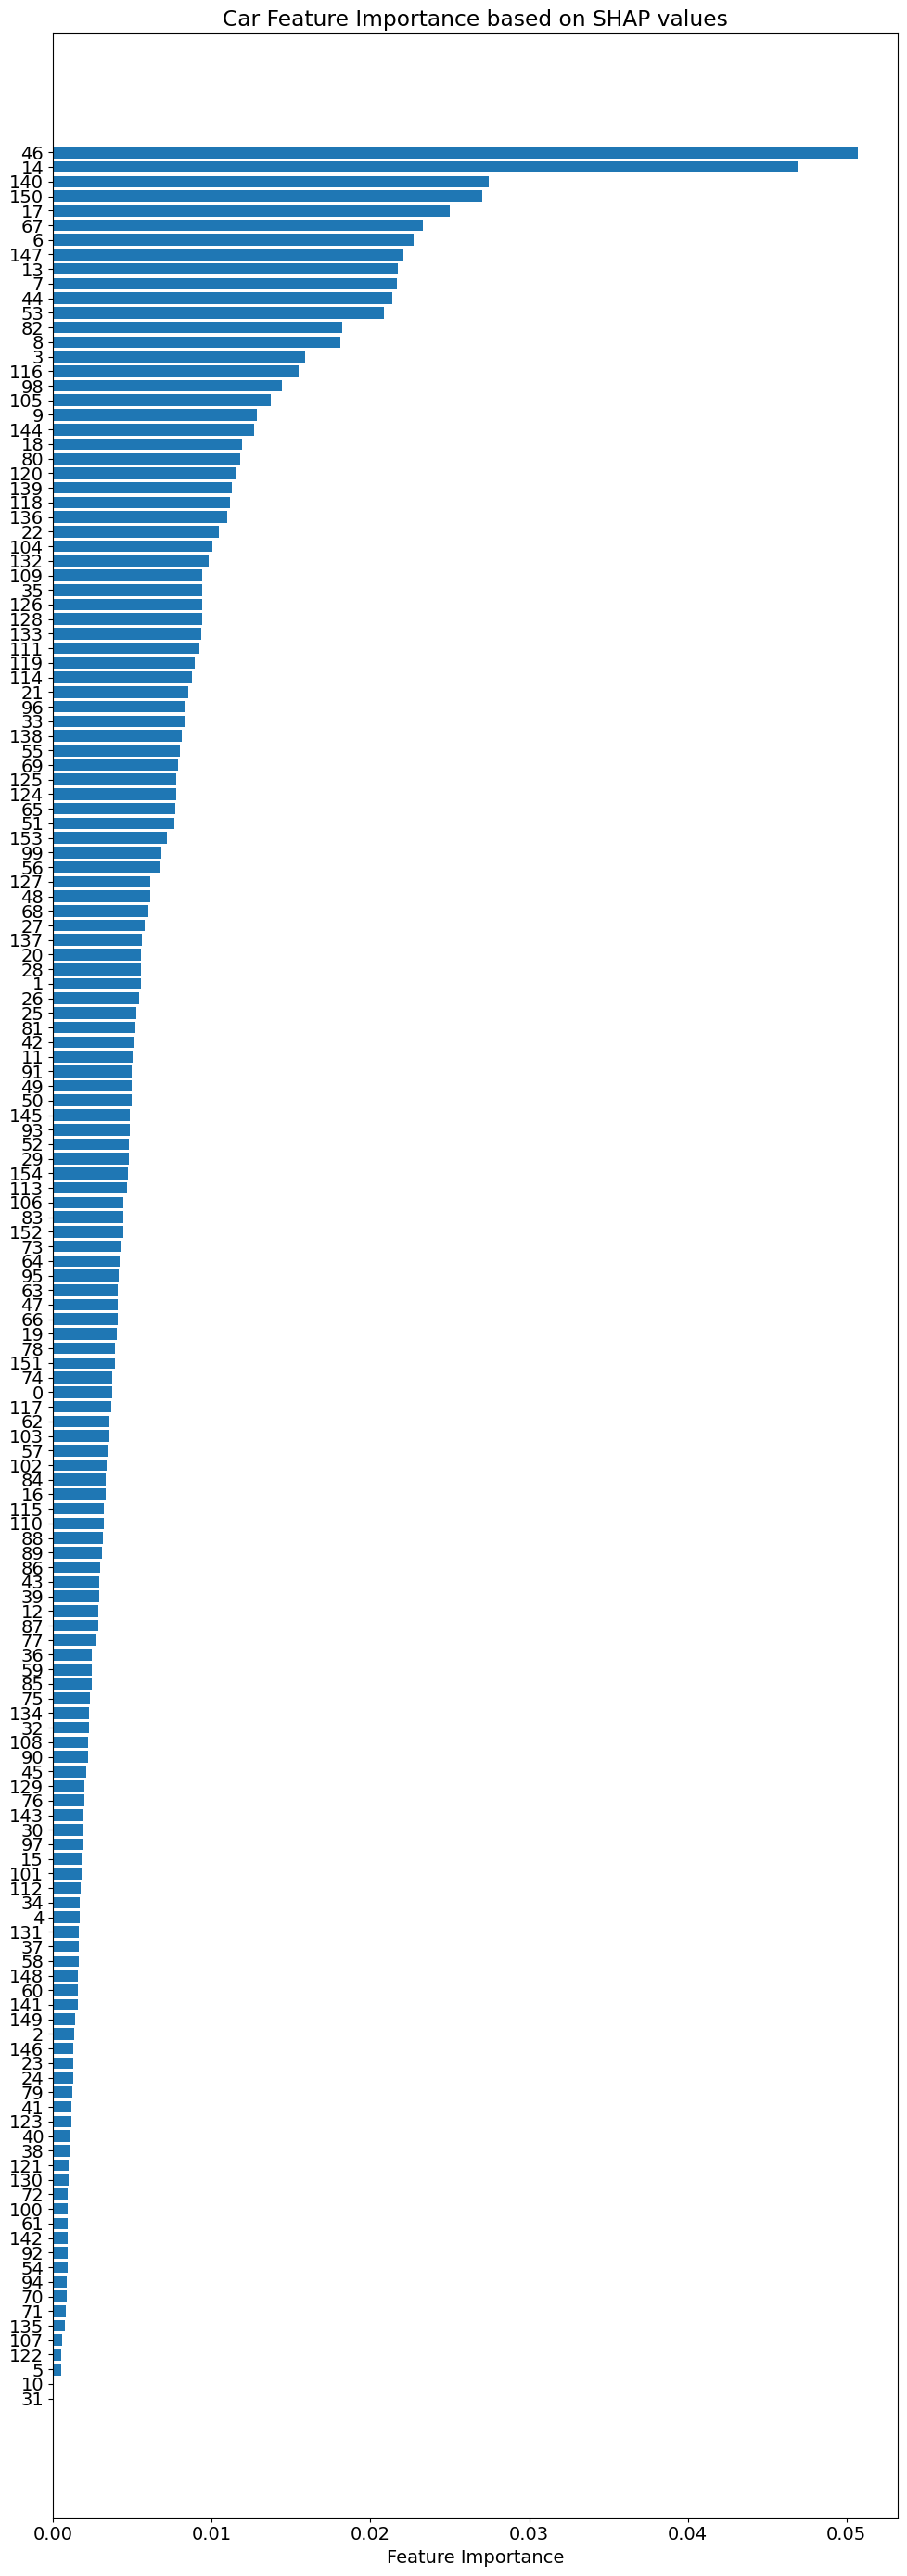

In [ ]:
# 绘制用户特征重要性
plt.figure(figsize=(10, 8))
sorted_idx_user = mean_shap_user_e8.argsort()
plt.barh(range(new_user_scal.shape[1]), mean_shap_user_e8[sorted_idx_user])
plt.yticks(range(new_user_scal.shape[1]), sorted_idx_user)
plt.xlabel('Feature Importance')
plt.title('User Feature Importance based on SHAP values')
plt.tight_layout()
plt.show()

# 绘制汽车特征重要性
plt.figure(figsize=(10, 28))
sorted_idx_car = mean_shap_car_e8.argsort()
plt.barh(range(new_car_scal.shape[1]), mean_shap_car_e8[sorted_idx_car])
plt.yticks(range(new_car_scal.shape[1]), sorted_idx_car)
plt.xlabel('Feature Importance')
plt.title('Car Feature Importance based on SHAP values')
plt.tight_layout()
plt.show()
